In [1]:
import numpy as np
from scipy.integrate import odeint
import math
import random
import time
import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import matplotlib.pyplot as plt

In [2]:
d_m=math.log(2)/5
d_p=math.log(2)/600
B=0.1
R=1
T=1
factor=2 #conv sec to min
features={
    #RNAP binding free energy, kcal/mol
    'dG_RNAP':{"offtarget":-4*R,
                 "Phlf":-4.7*R,
                 "Srpr":-4.4*R,
                 "BetI":-4.7*R,#
                 "HlyllR":-4.7*R,
                 "AmtR":-4.8*R,
                 "LacI":-4.5*R,#
                 "TetR":-4.7*R,#
                 "AraC":-4.5*R,#
                 "Con_A":-4*R,#
                 "Con_I":-4*R,#
                 "KanR":-4*R,#
                 "StrepR":-4*R#
                },#tbd
    #TF binding free energy, kcal/mol
    'dG_TF':{"offtarget":-4*T,
                 "Phlf":-9*T,
                 "Srpr":-7.5*T,
                 "BetI":-8*T,#
                 "HlyllR":-6.5*T,
                 "AmtR":-9*T,
                 "TetR":-7.5*T,#
                 "AraC":-8*T,#
                 "LacI":-8*T#
                }, #tbd
    #inactive binding free energy
    'dG_Inactive':{'TetR':-2.0,#
                  'LacI':-2.0,#
                  'AraC':-2.0},#
    #mRNA deg rate, 1/min
    'd_mRNA':{"Phlf":d_m,#
                  "Srpr":d_m,#
                  "BetI":d_m,#
                  "HlyllR":d_m,#
                  "AmtR":d_m,#
                  "YFP":d_m,#
                  "LacI_TetR":d_m,#
                  "AraC":d_m,#
                  "KanR":d_m,#
                  "StrepR":d_m #
                }, #tbd github/cidarlab?
    #Translation rate, protein/mRNA/min
    'beta':{"Phlf":1,#
                  "Srpr":1,#
                  "BetI":1,#
                  "HlyllR":1,#
                  "AmtR":1,#
                  "YFP":1,#
                  "LacI":1,#
                  "AraC":1,#
                  "TetR":1,#
                  "KanR":1,#
                  "StrepR":1#
                },
#TIRS from RBS calc converted to proteins/mrna/min
 #   'beta':{"Phlf":0.36*B,#
 #                 "Srpr":5*B,#
 #                 "BetI":1.6*B,#
 #                 "HlyllR":0.13*B,#
 #                 "AmtR":1.35*B,#
 #                 "YFP":0.28*B,#
 #                 "LacI":44*B,#
 #                 "AraC":32*B,#
 #                 "TetR":61*B,#
 #                 "KanR":37*B,#
 #                 "StrepR":0.24*B#
 #               },
    #number of TF binding sites in promoter
    'N_ontarget':{"Phlf":5,#
                  "Srpr":10,#
                  "BetI":10,#
                  "HlyllR":20,#
                  "AmtR":5,#
                  "LacI":10,#
                  "TetR":10,#
                  "AraC":20,#
                }, #tbd
    # number of free RNAP
    'N_RNAP':750,#
    # number of free Ribosomes
    'N_RIBO':1000, #
    #protein deg rates, 1/min
    'd_Protein':{"Phlf":d_p,#
                  "Srpr":d_p,#
                  "BetI":d_p,#
                  "HlyllR":d_p,#
                  "AmtR":d_p,#
                  "YFP":d_p,#
                  "LacI":d_p,#
                  "AraC":d_p,#
                  "TetR":d_p,#
                  "KanR":d_p,#
                  "StrepR":d_p#
                }, #tbd
    #growth rate, 1/min
    'mu':math.log(2)/45, #tbd
    #max promoter transcription rate mRNA/promoter/min
    'a_max':{"Phlf":3*factor,
                  "Srpr":3*factor,
                  "BetI":1.7*factor,#
                  "HlyllR":2.5*factor,
                  "AmtR":1.5*factor,
                  "LacI":2*factor,#
                  "TetR":3*factor,#
                  "AraC":2*factor,#
                  "Con_A":1*factor,
                  "Con_I":1*factor,
                  "KanR":2*factor,
                  "StrepR":2*factor
                },
    #genome length
    'genome_len':4600000,
    #copy number of circuit    
    "copy_number":{"Phlf":10,
                  "Srpr":10,
                  "BetI":10,
                  "HlyllR":10,
                  "AmtR":10,
                  "YFP":5,
                  "LacI_TetR":10,
                  "AraC":10,
                  "KanR":10,
                  "StrepR":5},
    
    #inducer concentrations used mM
    'inducers':{'AraC':0,
                'TetR':0,
                'LacI':0
                },
    #kd of inducers
    'iKd':{'AraC': 0.05,#
           'LacI': 0.05,#
           'TetR':0.005 #
                },
    # temperature
    'T':310,
    
    'co_op':{"Phlf":1,#
                  "Srpr":1,#
                  "BetI":1,#
                  "HlyllR":1,#
                  "AmtR":1,#
                  "LacI":1,#
                  "TetR":1,#
                  "AraC":2,}
    
    }

#cooperativity
#    'co_op':{'AraC':2,#
#             'LacI':2,#
#             'TetR':2#
#                },
#kd for hill functions
#'Kd':{'AraC':5,#
#          'LacI':5,#
#          'TetR':5}

In [3]:
def Partition_fxn(a_max,dG_RNAP,N_RNAP,dG_TFoff,dG_Active,dG_Inactive, 
                  N_Bindingsites,cooperativity,N_Repressors,fractionActive,genome_len,T):
    RT=T*1.987/1000 #temperature(kelvin)*R(kcal/K/mol)

    P_RNAP=N_RNAP*math.exp(-dG_RNAP/RT)/genome_len
    P_Active=((1 + N_Repressors * fractionActive * math.exp(- (dG_Active)) / genome_len)**N_Bindingsites) - 1
    P_Inactive=((1 + N_Repressors * (1 - fractionActive) * math.exp(-(dG_Inactive)) / genome_len)**N_Bindingsites) -1;
    
    if cooperativity>1:
        Pbound=P_RNAP / (1 + P_RNAP + cooperativity*(P_Active + P_Inactive)+(P_Active + P_Inactive)**cooperativity)
    else:
        Pbound=P_RNAP / (1 + P_RNAP + (P_Active + P_Inactive))
    alpha=a_max*Pbound
    return alpha

def Hill_function_R(a_max,Kd,cooperativity,N_Repressor):
    alpha = a_max/(1 + (N_Repressor/Kd)**cooperativity);
    return alpha

def Hill_function_A(a_max,Ka,cooperativity,N_Activator):
    alpha = a_max*((N_Activator)**cooperativity)/(Ka**cooperativity + (N_Repressor)**cooperativity);
    return alpha

In [4]:
def rule_30_circuit(y,t,features):
    n_strep=y[0]
    m_strep=y[1]
    p_strep=y[2]
    
    n_kan=y[3]
    m_kan=y[4]
    p_kan=y[5]
    
    n_ara=y[6]
    m_ara=y[7]
    p_ara=y[8]
    
    n_lac=y[9]
    m_lac=y[10]
    p_lac=y[11]
    p_tet=y[12]
    
    n_Phlf=y[13]
    m_Phlf=y[14]
    p_Phlf=y[15]
    
    n_Srpr=y[16]
    m_Srpr=y[17]
    p_Srpr=y[18]
    
    n_BetI=y[19]
    m_BetI=y[20]
    p_BetI=y[21]

    n_HlyllR=y[22]
    m_HlyllR=y[23]
    p_HlyllR=y[24]
    
    n_AmtR=y[25]
    m_AmtR=y[26]
    p_AmtR=y[27]
    
    n_YFP=y[28]
    m_YFP=y[29]
    p_YFP=y[30]
    
    fractionActive_ara=1/(1+features["inducers"]["AraC"]/features['iKd']['AraC']) 
    fractionActive_lac=1/(1+features["inducers"]["LacI"]/features['iKd']['LacI'])
    fractionActive_tet=1/(1+features["inducers"]["TetR"]/features['iKd']['TetR'])
    
    #print fractionActive_lac
    
    alpha_strep=Partition_fxn(features['a_max']['StrepR'],features['dG_RNAP']['StrepR'],features['N_RNAP'],0,0,0, 
                  0,0,0,0,features['genome_len'],features['T'])
    alpha_kan=Partition_fxn(features['a_max']['KanR'],features['dG_RNAP']['KanR'],features['N_RNAP'],0,0,0, 
                  0,0,0,0,features['genome_len'],features['T'])
    alpha_con_a=Partition_fxn(features['a_max']['Con_A'],features['dG_RNAP']['Con_A'],features['N_RNAP'],0,0,0, 
                  0,0,0,0,features['genome_len'],features['T'])
    alpha_con_L_T=Partition_fxn(features['a_max']['Con_I'],features['dG_RNAP']['Con_I'],features['N_RNAP'],0,0,0, 
                  0,0,0,0,features['genome_len'],features['T'])
    alpha_ara=Partition_fxn(features['a_max']['AraC'],features['dG_RNAP']['AraC'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['AraC'],features['dG_Inactive']['AraC'], 
                  features['N_ontarget']['AraC'],features['co_op']['AraC'],p_ara,fractionActive_ara,features['genome_len'],features['T'])
    alpha_tet=Partition_fxn(features['a_max']['TetR'],features['dG_RNAP']['TetR'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['TetR'],features['dG_Inactive']['TetR'], 
                  features['N_ontarget']['TetR'],features['co_op']['TetR'],p_tet,fractionActive_tet,features['genome_len'],features['T'])
    alpha_lac=Partition_fxn(features['a_max']['LacI'],features['dG_RNAP']['LacI'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['LacI'],features['dG_Inactive']['LacI'], 
                  features['N_ontarget']['LacI'],features['co_op']['LacI'],p_lac,fractionActive_lac,features['genome_len'],features['T'])
    alpha_Phlf=Partition_fxn(features['a_max']['Phlf'],features['dG_RNAP']['Phlf'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['Phlf'],0, 
                  features['N_ontarget']['Phlf'],features['co_op']['Phlf'],p_Phlf,1,features['genome_len'],features['T'])
    alpha_Srpr=Partition_fxn(features['a_max']['Srpr'],features['dG_RNAP']['Srpr'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['Srpr'],0, 
                  features['N_ontarget']['Srpr'],features['co_op']['Srpr'],p_Srpr,1,features['genome_len'],features['T'])
    alpha_BetI=Partition_fxn(features['a_max']['BetI'],features['dG_RNAP']['BetI'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['BetI'],0, 
                  features['N_ontarget']['BetI'],features['co_op']['BetI'],p_BetI,1,features['genome_len'],features['T'])
    alpha_AmtR=Partition_fxn(features['a_max']['AmtR'],features['dG_RNAP']['AmtR'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['AmtR'],0, 
                  features['N_ontarget']['AmtR'],features['co_op']['AmtR'],p_AmtR,1,features['genome_len'],features['T'])
    alpha_HlyllR=Partition_fxn(features['a_max']['HlyllR'],features['dG_RNAP']['HlyllR'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['HlyllR'],0, 
                  features['N_ontarget']['HlyllR'],features['co_op']['HlyllR'],p_HlyllR,1,features['genome_len'],features['T'])
    
    #print alpha_HlyllR
    
    dy=np.zeros(len(y))
    
    dy[0]=0
    dy[1]=alpha_strep*n_strep-features['d_mRNA']['StrepR']*m_strep-features['mu']*m_strep
    dy[2]=features['beta']['StrepR']*m_strep-features['d_Protein']['StrepR']*p_strep-features['mu']*p_strep

    dy[3]=0
    dy[4]=alpha_kan*n_kan-features['d_mRNA']['KanR']*m_kan-features['mu']*m_kan
    dy[5]=features['beta']['KanR']*m_kan-features['d_Protein']['KanR']*p_kan-features['mu']*p_kan
                                                                                    
    dy[6]=0
    dy[7]=alpha_con_a*n_ara-features['d_mRNA']['AraC']*m_ara-features['mu']*m_ara
    dy[8]=features['beta']['AraC']*m_ara-features['d_Protein']['AraC']*p_ara-features['mu']*p_ara
    
    dy[9]=0
    dy[10]=alpha_con_L_T*n_lac-features['d_mRNA']['LacI_TetR']*m_lac-features['mu']*m_lac
    dy[11]=features['beta']['LacI']*m_lac-features['d_Protein']['LacI']*p_lac-features['mu']*p_lac

    dy[12]=features['beta']['TetR']*m_lac-features['d_Protein']['TetR']*p_tet-features['mu']*p_tet
                                                                                    
    dy[13]=0
    dy[14]=(alpha_Srpr+alpha_BetI)*n_Phlf-features['d_mRNA']['Phlf']*m_Phlf-features['mu']*m_Phlf
    dy[15]=features['beta']['Phlf']*m_Phlf-features['d_Protein']['Phlf']*p_Phlf-features['mu']*p_Phlf
    
    dy[16]=0
    dy[17]=alpha_ara*n_Srpr-features['d_mRNA']['Srpr']*m_Srpr-features['mu']*m_Srpr
    dy[18]=features['beta']['Srpr']*m_Srpr-features['d_Protein']['Srpr']*p_Srpr-features['mu']*p_Srpr

    dy[19]=0
    dy[20]=alpha_HlyllR*n_BetI-features['d_mRNA']['BetI']*m_BetI-features['mu']*m_BetI
    dy[21]=features['beta']['BetI']*m_BetI-features['d_Protein']['BetI']*p_BetI-features['mu']*p_BetI
                                                                        
    dy[22]=0
    dy[23]=(alpha_tet+alpha_lac)*n_HlyllR-features['d_mRNA']['HlyllR']*m_HlyllR-features['mu']*m_HlyllR
    dy[24]=features['beta']['HlyllR']*m_HlyllR-features['d_Protein']['HlyllR']*p_HlyllR-features['mu']*p_HlyllR

    dy[25]=0
    dy[26]=(alpha_ara+alpha_HlyllR)*n_AmtR-features['d_mRNA']['AmtR']*m_AmtR-features['mu']*m_AmtR
    dy[27]=features['beta']['AmtR']*m_AmtR-features['d_Protein']['AmtR']*p_AmtR-features['mu']*p_AmtR
    
    dy[28]=0
    dy[29]=(alpha_Phlf+alpha_AmtR)*n_YFP-features['d_mRNA']['YFP']*m_YFP-features['mu']*m_YFP
    dy[30]=features['beta']['YFP']*m_YFP-features['d_Protein']['YFP']*p_YFP-features['mu']*p_YFP
    
    return dy

In [5]:
# Plots the solution to circuit model
def circuit_char(time_points, solution):
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(24, 24))
    
    ax1.set_ylim((0, 200))
    ax2.set_ylim((0, 2000))
    ax3.set_ylim((0, 500))
    ax4.set_ylim((0, 10000))

    
    ax1.set_title('YFP mRNA levels')
    ax1.plot(time_points, solution[:, 29], 'orange')
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('mRNAs')

    ax2.set_title('YFP protein levels')
    ax2.plot(time_points, solution[:, 30], 'orange')
    ax2.set_xlabel('Time (minutes)')
    ax2.set_ylabel('Proteins')
    
    ax3.set_title('TF mRNA levels')
    ax3.plot(time_points, solution[:, 14], 'r')
    ax3.plot(time_points, solution[:, 17], 'y')
    ax3.plot(time_points, solution[:, 20], 'g')
    ax3.plot(time_points, solution[:, 23], 'b')
    ax3.plot(time_points, solution[:, 26], 'm')
    ax3.legend(['Phlf', 'Srpr', 'BetI','HlyllR', 'AmtR'])
    ax3.set_xlabel('Time (minutes)')
    ax3.set_ylabel('mRNAs')

    ax4.set_title('TF protein levels')
    ax4.plot(time_points, solution[:, 15], 'r')
    ax4.plot(time_points, solution[:, 16], 'y')
    ax4.plot(time_points, solution[:, 21], 'g')
    ax4.plot(time_points, solution[:, 24], 'b')
    ax4.plot(time_points, solution[:, 27], 'm')
    ax4.legend(['Phlf', 'Srpr', 'BetI','HlyllR', 'AmtR'])
    ax4.set_xlabel('Time (minutes)')
    ax4.set_ylabel('Proteins')

    fig.subplots_adjust(hspace=0.5)

    plt.show()

In [6]:
# Solves circuit model function
def solve_circuit(induction_conditions,features, verbose=True):
    
    t = np.linspace(0, 300, 1000)

    h0 = np.zeros(31)
    h0[0]=features['copy_number']['StrepR']
    h0[3]=features['copy_number']['KanR']
    h0[6]=features['copy_number']['AraC']
    h0[9]=features['copy_number']['LacI_TetR']
    h0[13]=features['copy_number']['Phlf']
    h0[16]=features['copy_number']['Srpr']
    h0[19]=features['copy_number']['BetI']
    h0[22]=features['copy_number']['HlyllR']
    h0[25]=features['copy_number']['AmtR']
    h0[28]=features['copy_number']['YFP']
    
    features['inducers']['LacI']=0
    features['inducers']['TetR']=0
    features['inducers']['AraC']=0
    
    y = odeint(rule_30_circuit, h0, t, (features,))

    # circuit_char(t, y)

    h0=y[-1,:]

    # induction
    
    features['inducers']['LacI']=induction_conditions[0]
    features['inducers']['TetR']=induction_conditions[1]
    features['inducers']['AraC']=induction_conditions[2]
    
    y = odeint(rule_30_circuit, h0, t, (features,))

    if verbose:
        circuit_char(t, y)
        
    return y
                                                  
#solve_circuit([0,0,0],features)
#print "done!"

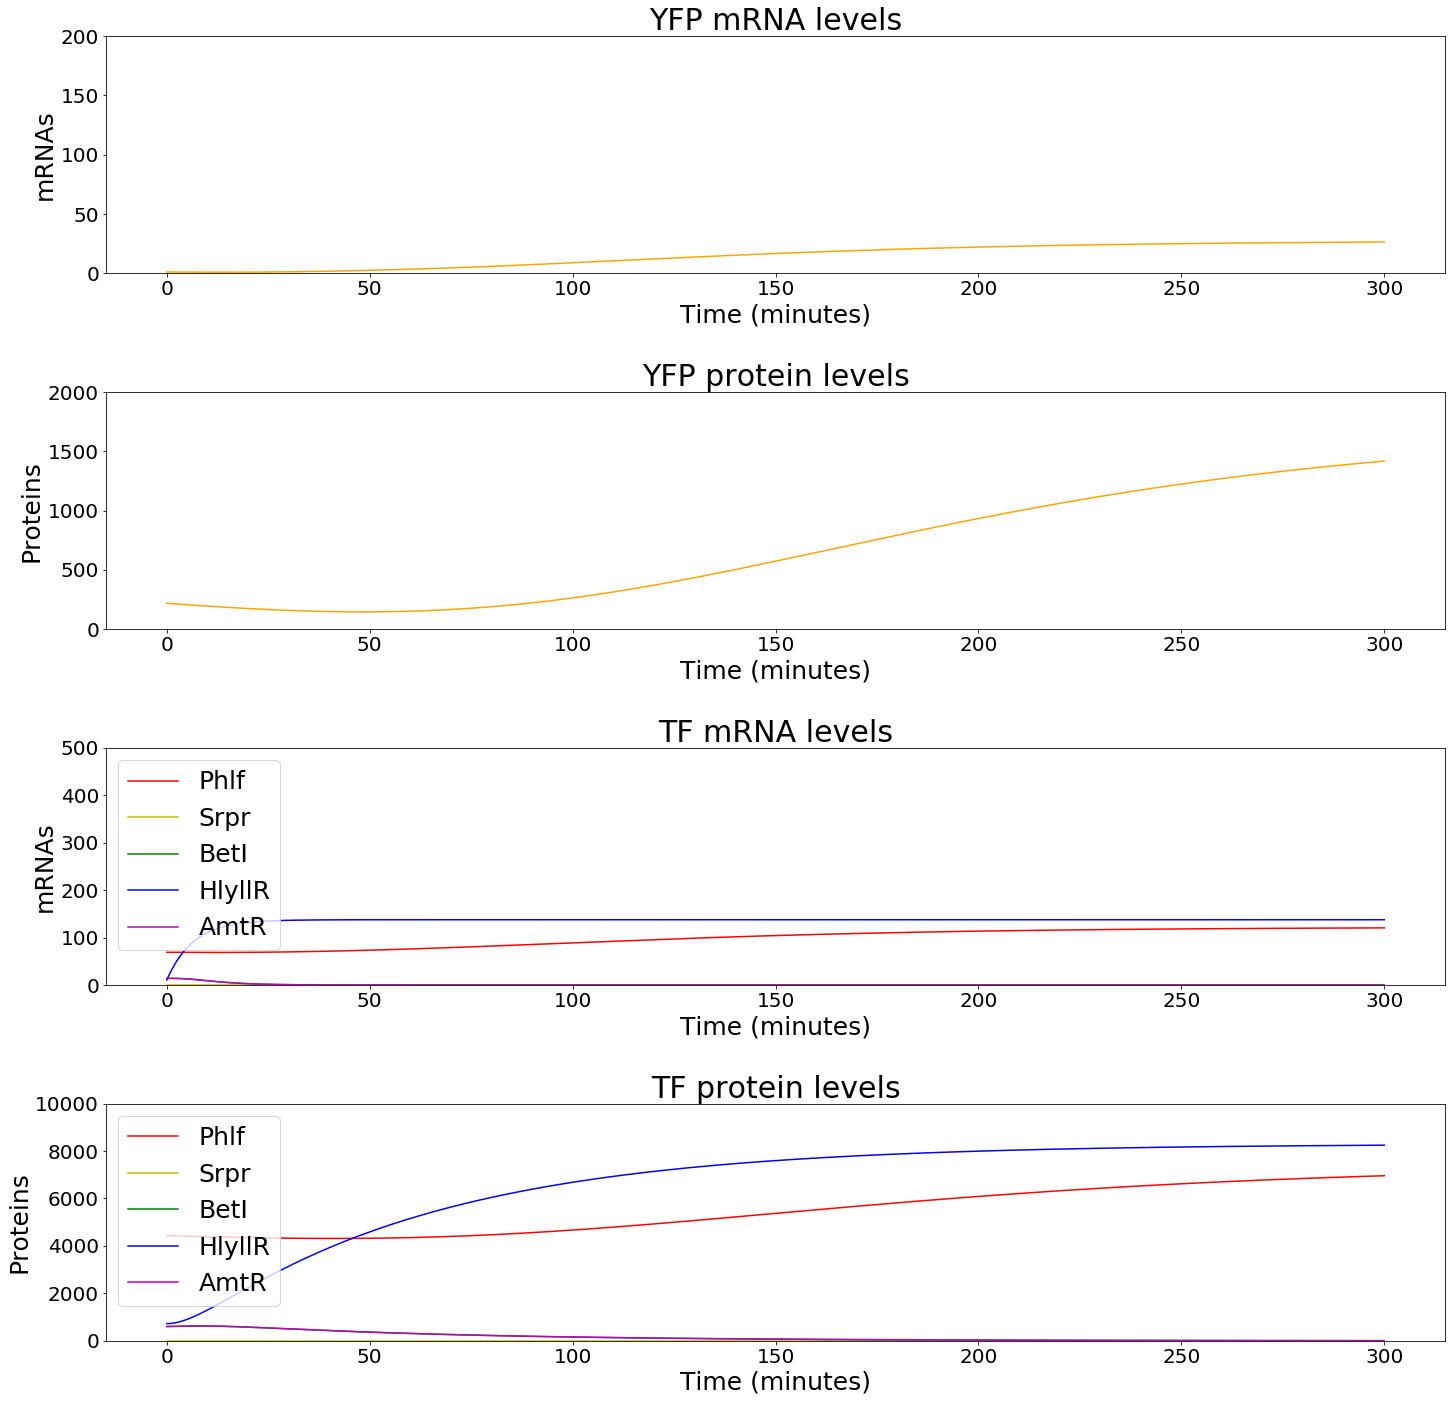

done!


In [7]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})
y = solve_circuit([1,1,0],features, verbose=True)
print "done!"

## Ptashne Steady State

In [8]:
def calc_Pt_number_serial(features, this_element, ups_element, trans_coupling):
    N=features['copy_number'][trans_coupling]
    a=features['a_max'][ups_element]    
    # print a
    D=features['N_ontarget'][this_element]
    dGR=float(features['dG_TF'][this_element])
    # print dGR
    B=features['beta'][this_element]
    d_m=features['d_mRNA'][trans_coupling]
    d_p=features['d_Protein'][this_element]
    # print 1/(d_m*d_p)
    u=features['mu']
    LG=features['genome_len']
    T=310
    RT=T*1.987/1000 #temperature(kelvin)*R(kcal/K/mol)
    # print RT
    R=a*B*N/((d_m+u)*(d_p+u))
    # print R
    # print math.exp(-dGR/RT)
    Pt=N*(math.exp(-dGR/RT)/LG)*R/(1+D*(math.exp(-dGR/RT)/LG))
    return Pt

In [9]:
dependency_graph = {
    "Phlf"  : (["BetI", "Srpr"], "Phlf"),
    "Srpr"  : (["AraC"], "Srpr"),
    "BetI"  : (["HlyllR"], "BetI"),
    "HlyllR": (["LacI", "TetR"], "HlyllR"),
    "AmtR"  : (["AraC", "HlyllR"], "AmtR")
}

In [10]:
from collections import defaultdict

In [11]:
ptashne_graph = defaultdict(lambda : defaultdict(float))

for this_element in dependency_graph:
    trans_coupling = dependency_graph[this_element][1]
    for ups_element in dependency_graph[this_element][0]:
        ptashne_graph[this_element][ups_element] = calc_Pt_number_serial(features, this_element, ups_element, trans_coupling)        

In [12]:
ptashne_graph

defaultdict(<function __main__.<lambda>>,
            {'AmtR': defaultdict(float,
                         {'AraC': 22163.32501070485,
                          'HlyllR': 27704.156263381064}),
             'BetI': defaultdict(float, {'HlyllR': 9550.257223523393}),
             'HlyllR': defaultdict(float,
                         {'LacI': 1118.6572185100572,
                          'TetR': 1677.985827765086}),
             'Phlf': defaultdict(float,
                         {'BetI': 18838.82625909912,
                          'Srpr': 33244.98751605728}),
             'Srpr': defaultdict(float, {'AraC': 4653.101640864158})})

## Context dependent Ptashne

In [13]:
def calc_Pt_number_context(features, this_element, trans_coupling, R):
    N=features['copy_number'][trans_coupling]
    D=features['N_ontarget'][this_element]
    dGR=float(features['dG_TF'][this_element])
    LG=features['genome_len']
    T=310
    RT=T*1.987/1000 #temperature(kelvin)*R(kcal/K/mol)
    Pt=N*(math.exp(-dGR/RT)/LG)*R/(1+D*(math.exp(-dGR/RT)/LG))
    return Pt

In [14]:
index_dict={"mRNA":{"Phlf":14,#
                  "Srpr":17,#
                  "BetI":20,#
                  "HlyllR":23,#
                  "AmtR":26,#
                  "YFP":29,#
                  "LacI":10,#
                  "AraC":7,#
                  "TetR":10#
                    },
             "protein":{"Phlf":15,#
                  "Srpr":18,#
                  "BetI":21,#
                  "HlyllR":24,#
                  "AmtR":27,#
                  "YFP":30,#
                  "LacI":11,#
                  "AraC":8,#
                  "TetR":12#
                     }
           }

In [15]:
prot_ptash_stash = {}

In [16]:
from itertools import product

In [17]:
for i, j, k in product([0, 1], repeat=3):
    y = solve_circuit([i, j, k], features, verbose=False)
    prot_ptash = defaultdict(lambda : defaultdict(float))
    for this_element in dependency_graph:
        trans_coupling = dependency_graph[this_element][1]
        prot_ptash[this_element] = calc_Pt_number_context(features, this_element, trans_coupling, y[-1][index_dict['protein'][this_element]])
    prot_ptash_stash[tuple([i, j, k])] = prot_ptash

In [18]:
prot_ptash_stash

{(0, 0, 0): defaultdict(<function __main__.<lambda>>,
             {'AmtR': 1520.516607829464,
              'BetI': 524.14513716875308,
              'HlyllR': 44.886365511107925,
              'Phlf': 5725.2034916067714,
              'Srpr': 0.0071650685735814533}),
 (0, 0, 1): defaultdict(<function __main__.<lambda>>,
             {'AmtR': 3390.377849713238,
              'BetI': 524.14513648709715,
              'HlyllR': 44.886365525234424,
              'Phlf': 221.23054049812825,
              'Srpr': 392.57707133472888}),
 (0, 1, 0): defaultdict(<function __main__.<lambda>>,
             {'AmtR': 8.7772442409048228,
              'BetI': 3.0139523729854574,
              'HlyllR': 415.38384422186692,
              'Phlf': 9807.4949877177351,
              'Srpr': 0.0071650709160937416}),
 (0, 1, 1): defaultdict(<function __main__.<lambda>>,
             {'AmtR': 1878.638487336962,
              'BetI': 3.0139524003210321,
              'HlyllR': 415.38384420981038,
           

## Monte Carlo -- Wowza!

In [19]:
import random
random.seed(1000)

### For data analysis comparison

In [60]:
# generate feature dictionary
def gen_feature_dict():
    p1=random.randint(7, 13)
    p2=random.randint(3, 7)
    features={
        #RNAP binding free energy, kcal/mol
        'dG_RNAP':{"offtarget":-4*R,
                     "Phlf":-4.7*R,
                     "Srpr":-4.4*R,
                     "BetI":-4.7*R,#
                     "HlyllR":-4.7*R,
                     "AmtR":-4.8*R,
                     "LacI":-4.5*R,#
                     "TetR":-4.7*R,#
                     "AraC":-4.5*R,#
                     "Con_A":-4*R,#
                     "Con_I":-4*R,#
                     "KanR":-4*R,#
                     "StrepR":-4*R#
                    },
        #TF binding free energy, kcal/mol
        'dG_TF':{"offtarget":-4*T,
                     "Phlf":-9*T,
                     "Srpr":-7.5*T,
                     "BetI":-8*T,#
                     "HlyllR":-6.5*T,
                     "AmtR":-9*T,
                     "TetR":-7.5*T,#
                     "AraC":-8*T,#
                     "LacI":-8*T#
                    },
        #inactive binding free energy
        'dG_Inactive':{'TetR':-2.0,#
                      'LacI':-2.0,#
                      'AraC':-2.0},#
        #mRNA deg rate, 1/min
        'd_mRNA':{"Phlf":d_m*random.uniform(0.7, 1.3),#
                      "Srpr":d_m*random.uniform(0.7, 1.3),#
                      "BetI":d_m*random.uniform(0.7, 1.3),#
                      "HlyllR":d_m*random.uniform(0.7, 1.3),#
                      "AmtR":d_m*random.uniform(0.7, 1.3),#
                      "YFP":d_m*random.uniform(0.7, 1.3),#
                      "LacI_TetR":d_m*random.uniform(0.7, 1.3),#
                      "AraC":d_m*random.uniform(0.7, 1.3),#
                      "KanR":d_m*random.uniform(0.7, 1.3),#
                      "StrepR":d_m*random.uniform(0.7, 1.3) #
                    },
        #Translation rate, protein/mRNA/min
        'beta':{"Phlf":random.uniform(0.7, 1.3),#
                      "Srpr":random.uniform(0.7, 1.3),#
                      "BetI":random.uniform(0.7, 1.3),#
                      "HlyllR":random.uniform(0.7, 1.3),#
                      "AmtR":random.uniform(0.7, 1.3),#
                      "YFP":random.uniform(0.7, 1.3),#
                      "LacI":random.uniform(0.7, 1.3),#
                      "AraC":random.uniform(0.7, 1.3),#
                      "TetR":random.uniform(0.7, 1.3),#
                      "KanR":random.uniform(0.7, 1.3),#
                      "StrepR":random.uniform(0.7, 1.3)#
                    },
        #number of TF binding sites in promoter
        'N_ontarget':{"Phlf":p2,#
                      "Srpr":p1,#
                      "BetI":p1,#
                      "HlyllR":2*p1,#
                      "AmtR":p2,#
                      "LacI":p1,#
                      "TetR":p1,#
                      "AraC":2*p1,#
                    }, #tbd
        # number of free RNAP
        'N_RNAP':750,#
        # number of free Ribosomes
        'N_RIBO':1000, #
        #protein deg rates, 1/min
        'd_Protein':{"Phlf":d_p*random.uniform(0.7, 1.3),#
                      "Srpr":d_p*random.uniform(0.7, 1.3),#
                      "BetI":d_p*random.uniform(0.7, 1.3),#
                      "HlyllR":d_p*random.uniform(0.7, 1.3),#
                      "AmtR":d_p*random.uniform(0.7, 1.3),#
                      "YFP":d_p*random.uniform(0.7, 1.3),#
                      "LacI":d_p*random.uniform(0.7, 1.3),#
                      "AraC":d_p*random.uniform(0.7, 1.3),#
                      "TetR":d_p*random.uniform(0.7, 1.3),#
                      "KanR":d_p*random.uniform(0.7, 1.3),#
                      "StrepR":d_p*random.uniform(0.7, 1.3)#
                    }, #tbd
        #growth rate, 1/min
        'mu': math.log(2)/45 * random.uniform(0.7, 1.3), #tbd
        #max promoter transcription rate mRNA/promoter/min
        'a_max':{"Phlf":random.randint(2, 4)*factor,
                      "Srpr":random.randint(2, 4)*factor,
                      "BetI":random.uniform(1.5, 1.9)*factor,#
                      "HlyllR":random.uniform(2.0, 3.0)*factor,
                      "AmtR":random.uniform(1, 2)*factor,
                      "LacI":random.uniform(1., 3.)*factor,#
                      "TetR":random.randint(2, 4)*factor,#
                      "AraC":random.randint(1, 3)*factor,#
                      "Con_A":random.uniform(0.5, 1.5)*factor,
                      "Con_I":random.uniform(0.5, 1.5)*factor,
                      "KanR":random.uniform(1., 3.)*factor,
                      "StrepR":random.uniform(1., 3.)*factor
                    },
        #genome length
        'genome_len':4600000,
        #copy number of circuit    
        "copy_number":{"Phlf":p1,
                      "Srpr":p1,
                      "BetI":p1,
                      "HlyllR":p1,
                      "AmtR":p1,
                      "YFP":p2,
                      "LacI_TetR":p1,
                      "AraC":p1,
                      "KanR":p1,
                      "StrepR":p2},

        #inducer concentrations used mM
        'inducers':{'AraC':0,
                    'TetR':0,
                    'LacI':0
                    },
        #kd of inducers
        'iKd':{'AraC': 0.05,#
               'LacI': 0.05,#
               'TetR':0.005 #
                    },
        # temperature
        'T':310,

        'co_op':{"Phlf":1,#
                      "Srpr":1,#
                      "BetI":1,#
                      "HlyllR":1,#
                      "AmtR":1,#
                      "LacI":1,#
                      "TetR":1,#
                      "AraC":2,}
    }
    return features

In [61]:
runs = 5000

In [62]:
def monte_carlo(feature_fn=gen_feature_dict):
    random.seed(5000)
    mRNA_mc_analysis = defaultdict(list)
    prot_mc_analysis = defaultdict(list)
    for run in xrange(runs):
        if run % 10 == 0:
            print run,
        fd = feature_fn()
        for i, j, k in product([0, 1], repeat=3):
            y = solve_circuit([i, j, k], fd, verbose=False)
            mRNA_mc_analysis[tuple([i, j, k])].append(y[-1][29])
            prot_mc_analysis[tuple([i, j, k])].append(y[-1][30])
    return mRNA_mc_analysis, prot_mc_analysis

In [23]:
mRNA_mc_analysis, prot_mc_analysis = monte_carlo()

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 2

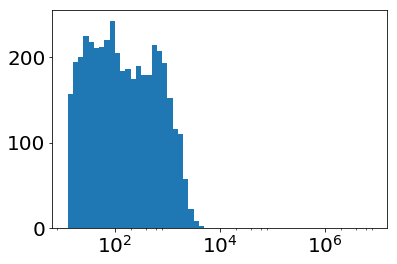

In [27]:
plt.hist(prot_mc_analysis[(0, 0, 1)],bins=np.logspace(1.1,6.9,59))
plt.gca().set_xscale('log')

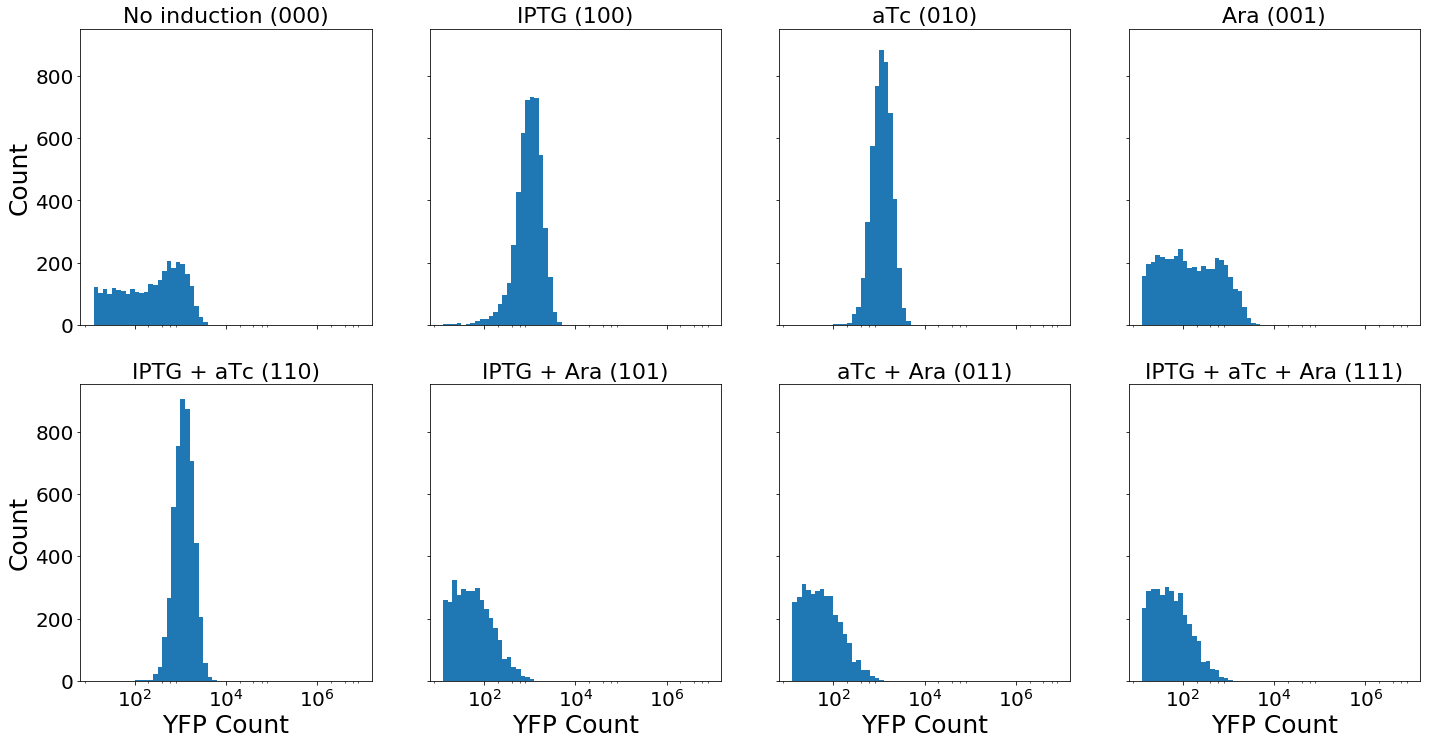

In [128]:
### Histogram for MC

fig, axes = plt.subplots(2, 4, figsize=(24, 12), sharey=True, sharex=True)

axes[0, 0].set_title('No induction (000)', fontdict={'fontsize':22})
axes[0, 0].hist(prot_mc_analysis[(0, 0, 0)],bins=np.logspace(1.1,6.9,59))
axes[0, 1].set_title('IPTG (100)', fontdict={'fontsize':22})
axes[0, 1].hist(prot_mc_analysis[(1, 0, 0)],bins=np.logspace(1.1,6.9,59))
axes[0, 2].set_title('aTc (010)', fontdict={'fontsize':22})
axes[0, 2].hist(prot_mc_analysis[(0, 1, 0)],bins=np.logspace(1.1,6.9,59))
axes[0, 3].set_title('Ara (001)', fontdict={'fontsize':22})
axes[0, 3].hist(prot_mc_analysis[(0, 0, 1)],bins=np.logspace(1.1,6.9,59))

axes[1, 0].set_title('IPTG + aTc (110)', fontdict={'fontsize':22})
axes[1, 0].hist(prot_mc_analysis[(1, 1, 0)],bins=np.logspace(1.1,6.9,59))
axes[1, 1].set_title('IPTG + Ara (101)', fontdict={'fontsize':22})
axes[1, 1].hist(prot_mc_analysis[(1, 0, 1)],bins=np.logspace(1.1,6.9,59))
axes[1, 2].set_title('aTc + Ara (011)', fontdict={'fontsize':22})
axes[1, 2].hist(prot_mc_analysis[(0, 1, 1)],bins=np.logspace(1.1,6.9,59))
axes[1, 3].set_title('IPTG + aTc + Ara (111)', fontdict={'fontsize':22})
axes[1, 3].hist(prot_mc_analysis[(1, 1, 1)],bins=np.logspace(1.1,6.9,59))

axes[0, 0].set_ylabel('Count')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xlabel('YFP Count')
axes[1, 1].set_xlabel('YFP Count')
axes[1, 2].set_xlabel('YFP Count')
axes[1, 3].set_xlabel('YFP Count')

plt.gca().set_xscale('log')
plt.savefig('Fig1.png', bbox_inches='tight', dpi=600)
plt.show()

In [90]:
# # write out unbinned csv
# with open('bree_mRNA_unbinned.csv', 'w') as out_file:
#     out_file.write(','.join([''.join(map(str, digit)) for digit in product([0, 1], repeat=3)])+'\n')
#     for run in xrange(runs):
#         out_file.write(','.join(str(mRNA_mc_analysis[tup][run]) for tup in product([0, 1], repeat=3))+'\n')

# with open('bree_prot_unbinned.csv', 'w') as out_file:
#     out_file.write(','.join([''.join(map(str, digit)) for digit in product([0, 1], repeat=3)])+'\n')
#     for run in xrange(runs):
#         out_file.write(','.join(str(prot_mc_analysis[tup][run]) for tup in product([0, 1], repeat=3))+'\n')

In [33]:
from scipy import stats

In [48]:
def get_binned(array_object):
    return list(stats.binned_statistic(array_object, array_object, statistic='count', bins=np.logspace(1.1,6.9,59)).statistic)

In [50]:
mRNA_mc_analysis_binned = {}
prot_mc_analysis_binned = {}

In [51]:
for tup in mRNA_mc_analysis:
    mRNA_mc_analysis_binned[tup] = get_binned(mRNA_mc_analysis[tup])
    prot_mc_analysis_binned[tup] = get_binned(prot_mc_analysis[tup])

In [54]:
# # write out binned csv
# with open('bree_mRNA_binned.csv', 'w') as out_file:
#     out_file.write(','.join([''.join(map(str, digit)) for digit in product([0, 1], repeat=3)])+'\n')
#     for run in xrange(58):
#         out_file.write(','.join(str(mRNA_mc_analysis_binned[tup][run]) for tup in product([0, 1], repeat=3))+'\n')

# with open('bree_prot_binned.csv', 'w') as out_file:
#     out_file.write(','.join([''.join(map(str, digit)) for digit in product([0, 1], repeat=3)])+'\n')
#     for run in xrange(58):
#         out_file.write(','.join(str(prot_mc_analysis_binned[tup][run]) for tup in product([0, 1], repeat=3))+'\n')

### For whole cell analysis

In [81]:
random.seed(1000)

In [82]:
# generate feature dictionary
def gen_feature_dict_wc():
    p1=random.randint(7, 13)
    p2=random.randint(3, 7)
    features={
        #RNAP binding free energy, kcal/mol
        'dG_RNAP':{"offtarget":-4*R*random.uniform(0.7, 1.3),
                     "Phlf":-4.7*R*random.uniform(0.7, 1.3),
                     "Srpr":-4.4*R*random.uniform(0.7, 1.3),
                     "BetI":-4.7*R*random.uniform(0.7, 1.3),#
                     "HlyllR":-4.7*R*random.uniform(0.7, 1.3),
                     "AmtR":-4.8*R*random.uniform(0.7, 1.3),
                     "LacI":-4.5*R*random.uniform(0.7, 1.3),#
                     "TetR":-4.7*R*random.uniform(0.7, 1.3),#
                     "AraC":-4.5*R*random.uniform(0.7, 1.3),#
                     "Con_A":-4*R*random.uniform(0.7, 1.3),#
                     "Con_I":-4*R*random.uniform(0.7, 1.3),#
                     "KanR":-4*R*random.uniform(0.7, 1.3),#
                     "StrepR":-4*R*random.uniform(0.7, 1.3)#
                    },
        #TF binding free energy, kcal/mol
        'dG_TF':{"offtarget":-4*T*random.uniform(0.7, 1.3),
                     "Phlf":-9*T*random.uniform(0.7, 1.3),
                     "Srpr":-7.5*T*random.uniform(0.7, 1.3),
                     "BetI":-8*T*random.uniform(0.7, 1.3),#
                     "HlyllR":-6.5*T*random.uniform(0.7, 1.3),
                     "AmtR":-9*T*random.uniform(0.7, 1.3),
                     "TetR":-7.5*T*random.uniform(0.7, 1.3),#
                     "AraC":-8*T*random.uniform(0.7, 1.3),#
                     "LacI":-8*T*random.uniform(0.7, 1.3)#
                    },
        #inactive binding free energy
        'dG_Inactive':{'TetR':-2.0*random.uniform(0.7, 1.3),#
                      'LacI':-2.0*random.uniform(0.7, 1.3),#
                      'AraC':-2.0*random.uniform(0.7, 1.3)},#
        #mRNA deg rate, 1/min
        'd_mRNA':{"Phlf":d_m*random.uniform(0.7, 1.3),#
                      "Srpr":d_m*random.uniform(0.7, 1.3),#
                      "BetI":d_m*random.uniform(0.7, 1.3),#
                      "HlyllR":d_m*random.uniform(0.7, 1.3),#
                      "AmtR":d_m*random.uniform(0.7, 1.3),#
                      "YFP":d_m*random.uniform(0.7, 1.3),#
                      "LacI_TetR":d_m*random.uniform(0.7, 1.3),#
                      "AraC":d_m*random.uniform(0.7, 1.3),#
                      "KanR":d_m*random.uniform(0.7, 1.3),#
                      "StrepR":d_m*random.uniform(0.7, 1.3) #
                    },
        #Translation rate, protein/mRNA/min
        'beta':{"Phlf":random.uniform(0.7, 1.3),#
                      "Srpr":random.uniform(0.7, 1.3),#
                      "BetI":random.uniform(0.7, 1.3),#
                      "HlyllR":random.uniform(0.7, 1.3),#
                      "AmtR":random.uniform(0.7, 1.3),#
                      "YFP":random.uniform(0.7, 1.3),#
                      "LacI":random.uniform(0.7, 1.3),#
                      "AraC":random.uniform(0.7, 1.3),#
                      "TetR":random.uniform(0.7, 1.3),#
                      "KanR":random.uniform(0.7, 1.3),#
                      "StrepR":random.uniform(0.7, 1.3)#
                    },
        #number of TF binding sites in promoter
        'N_ontarget':{"Phlf":p2*random.uniform(0.7, 1.3),#
                      "Srpr":p1*random.uniform(0.7, 1.3),#
                      "BetI":p1*random.uniform(0.7, 1.3),#
                      "HlyllR":2*p1*random.uniform(0.7, 1.3),#
                      "AmtR":p2*random.uniform(0.7, 1.3),#
                      "LacI":p1*random.uniform(0.7, 1.3),#
                      "TetR":p1*random.uniform(0.7, 1.3),#
                      "AraC":2*p1*random.uniform(0.7, 1.3),#
                    }, #tbd
        # number of free RNAP
        'N_RNAP':750,#
        # number of free Ribosomes
        'N_RIBO':1000, #
        #protein deg rates, 1/min
        'd_Protein':{"Phlf":d_p*random.uniform(0.7, 1.3),#
                      "Srpr":d_p*random.uniform(0.7, 1.3),#
                      "BetI":d_p*random.uniform(0.7, 1.3),#
                      "HlyllR":d_p*random.uniform(0.7, 1.3),#
                      "AmtR":d_p*random.uniform(0.7, 1.3),#
                      "YFP":d_p*random.uniform(0.7, 1.3),#
                      "LacI":d_p*random.uniform(0.7, 1.3),#
                      "AraC":d_p*random.uniform(0.7, 1.3),#
                      "TetR":d_p*random.uniform(0.7, 1.3),#
                      "KanR":d_p*random.uniform(0.7, 1.3),#
                      "StrepR":d_p*random.uniform(0.7, 1.3)#
                    }, #tbd
        #growth rate, 1/min
        'mu': math.log(2)/45 * random.uniform(0.7, 1.3), #tbd
        #max promoter transcription rate mRNA/promoter/min
        'a_max':{"Phlf":random.randint(2, 4)*factor,
                      "Srpr":random.randint(2, 4)*factor,
                      "BetI":random.uniform(1.5, 1.9)*factor,#
                      "HlyllR":random.uniform(2.0, 3.0)*factor,
                      "AmtR":random.uniform(1, 2)*factor,
                      "LacI":random.uniform(1., 3.)*factor,#
                      "TetR":random.randint(2, 4)*factor,#
                      "AraC":random.randint(1, 3)*factor,#
                      "Con_A":random.uniform(0.5, 1.5)*factor,
                      "Con_I":random.uniform(0.5, 1.5)*factor,
                      "KanR":random.uniform(1., 3.)*factor,
                      "StrepR":random.uniform(1., 3.)*factor
                    },
        #genome length
        'genome_len':4600000,
        #copy number of circuit    
        "copy_number":{"Phlf":p1*random.uniform(0.7, 1.3),
                      "Srpr":p1*random.uniform(0.7, 1.3),
                      "BetI":p1*random.uniform(0.7, 1.3),
                      "HlyllR":p1*random.uniform(0.7, 1.3),
                      "AmtR":p1*random.uniform(0.7, 1.3),
                      "YFP":p2*random.uniform(0.7, 1.3),
                      "LacI_TetR":p1*random.uniform(0.7, 1.3),
                      "AraC":p1*random.uniform(0.7, 1.3),
                      "KanR":p1*random.uniform(0.7, 1.3),
                      "StrepR":p2*random.uniform(0.7, 1.3)},

        #inducer concentrations used mM
        'inducers':{'AraC':0,
                    'TetR':0,
                    'LacI':0
                    },
        #kd of inducers
        'iKd':{'AraC': 0.05*random.uniform(0.7, 1.3),#
               'LacI': 0.05*random.uniform(0.7, 1.3),#
               'TetR':0.005*random.uniform(0.7, 1.3) #
                    },
r        # temperature
        'T':310,

        'co_op':{"Phlf":1*random.uniform(0.7, 1.3),#
                      "Srpr":1*random.uniform(0.7, 1.3),#
                      "BetI":1*random.uniform(0.7, 1.3),#
                      "HlyllR":1*random.uniform(0.7, 1.3),#
                      "AmtR":1*random.uniform(0.7, 1.3),#
                      "LacI":1*random.uniform(0.7, 1.3),#
                      "TetR":1*random.uniform(0.7, 1.3),#
                      "AraC":2*random.uniform(0.7, 1.3),}
    }
    return features

In [152]:
def monte_carlo_wc(feature_fn=gen_feature_dict_wc):
    random.seed(5000)
    mRNA_mc_analysis = defaultdict(list)
    prot_mc_analysis = defaultdict(list)
    for run in xrange(runs):
        if run % 10 == 0:
            print run,
        fd = feature_fn()
        for i, j, k in product([0, 1], repeat=3):
            y = solve_circuit([i, j, k], fd, verbose=False)
            mRNA_mc_analysis[tuple([i, j, k])].append(y[:,29])
            prot_mc_analysis[tuple([i, j, k])].append(y[:,30])
    return mRNA_mc_analysis, prot_mc_analysis

In [153]:
mRNA_mc_analysis_wc, prot_mc_analysis_wc = monte_carlo_wc()

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 2

In [157]:
len(mRNA_mc_analysis_wc[tuple([0, 0, 0])][0])

1000

In [166]:
import statistics

ImportError: No module named statistics

In [173]:
mRNA_final = {tuple(x): {'mean':[], 'mean+std':[], 'mean-std':[]} for x in product([0,1], repeat=3)}
prot_final = {tuple(x): {'mean':[], 'mean+std':[], 'mean-std':[]} for x in product([0,1], repeat=3)}

for tup in product([0,1], repeat=3):
    print tup
    for col in xrange(1000):
        vec1 = []
        vec2 = []
        for row in xrange(5000):
            vec1.append(mRNA_mc_analysis_wc[tup][row][col])
            vec2.append(prot_mc_analysis_wc[tup][row][col])
        
        vec1 = np.array(vec1)
        vec2 = np.array(vec2)
        
        mean = np.mean(vec1)
        stdv = np.std(vec1)
        mRNA_final[tup]['mean-std'].append(mean-stdv)
        mRNA_final[tup]['mean'].append(mean)
        mRNA_final[tup]['mean+std'].append(mean+stdv)
        
        mean = np.mean(vec2)
        stdv = np.std(vec2)
        prot_final[tup]['mean-std'].append(mean-stdv)
        prot_final[tup]['mean'].append(mean)
        prot_final[tup]['mean+std'].append(mean+stdv)

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)


In [174]:
x_labels = range(1000)

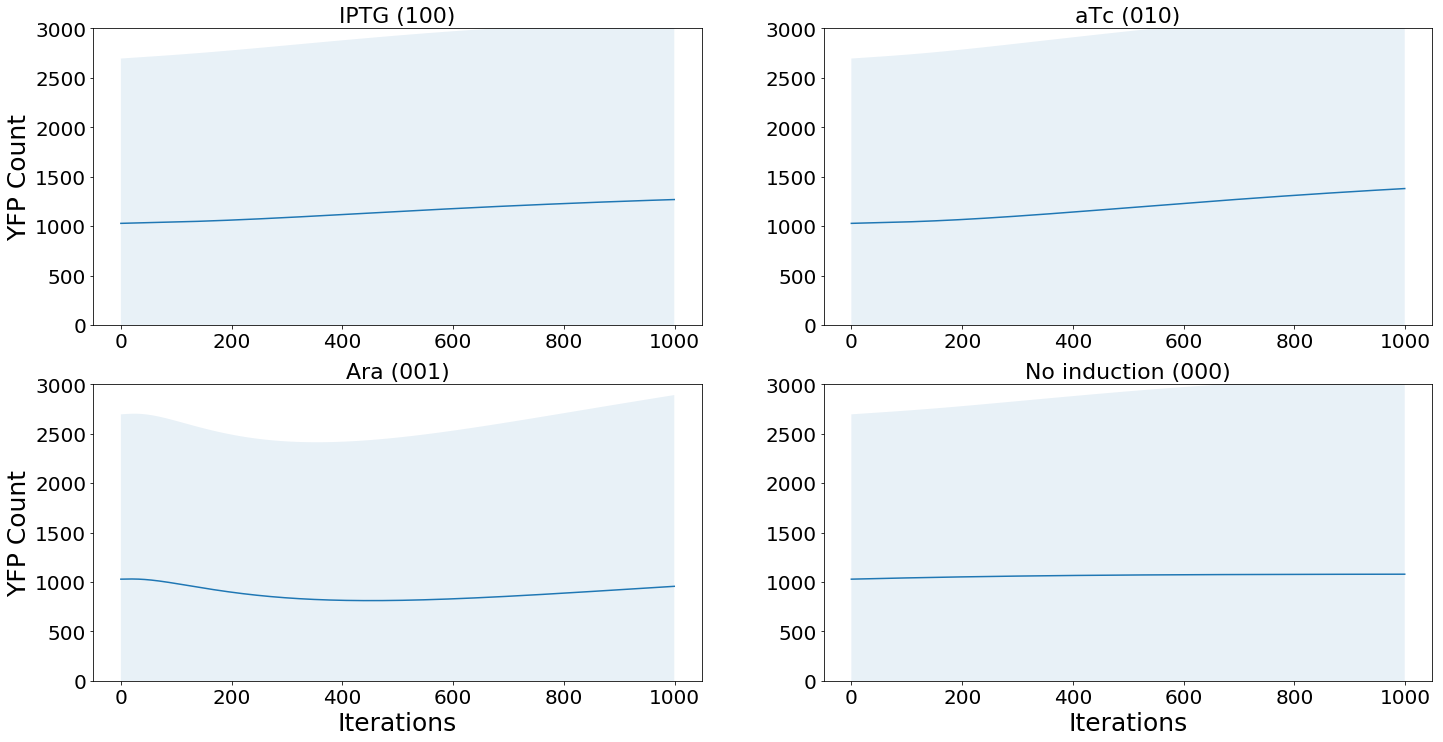

In [205]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12))

axes[0, 0].set_title('IPTG (100)', fontdict={'fontsize':22})
axes[0, 0].plot(x_labels, prot_final[(1, 0, 0)]['mean'], label=x_labels)
axes[0, 0].fill_between(x_labels, prot_final[(1, 0, 0)]['mean-std'], prot_final[(1, 0, 0)]['mean+std'], alpha=0.1)

axes[0, 1].set_title('aTc (010)', fontdict={'fontsize':22})
axes[0, 1].plot(x_labels, prot_final[(0, 1, 0)]['mean'], label=x_labels)
axes[0, 1].fill_between(x_labels, prot_final[(0, 1, 0)]['mean-std'], prot_final[(0, 1, 0)]['mean+std'], alpha=0.1)

axes[1, 0].set_title('Ara (001)', fontdict={'fontsize':22})
axes[1, 0].plot(x_labels, prot_final[(0, 0, 1)]['mean'], label=x_labels)
axes[1, 0].fill_between(x_labels, prot_final[(0, 0, 1)]['mean-std'], prot_final[(0, 0, 1)]['mean+std'], alpha=0.1)

axes[1, 1].set_title('No induction (000)', fontdict={'fontsize':22})
axes[1, 1].plot(x_labels, prot_final[(0, 0, 0)]['mean'], label=x_labels)
axes[1, 1].fill_between(x_labels, prot_final[(1, 0, 0)]['mean-std'], prot_final[(1, 0, 0)]['mean+std'], alpha=0.1)

axes[0, 0].set_ylim([0, 3000])
axes[0, 1].set_ylim([0, 3000])
axes[1, 0].set_ylim([0, 3000])
axes[1, 1].set_ylim([0, 3000])

axes[0, 0].set_ylabel('YFP Count')
axes[1, 0].set_ylabel('YFP Count')
axes[1, 0].set_xlabel('Iterations')
axes[1, 1].set_xlabel('Iterations')

plt.show()